### Подход 1: градиентный бустинг "в лоб"
1. Считайте таблицу с признаками из файла features.csv. 

In [34]:
import pandas as pd
features = pd.read_csv('./features.csv', index_col='match_id')
features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


Удалите признаки, связанные с итогами матча.

In [22]:
X_prev = features.drop(['duration', 'radiant_win', 
'tower_status_radiant', 'tower_status_dire', 
'barracks_status_radiant', 'barracks_status_dire'], axis = 1)
X_prev.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0


2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [28]:
row_count = X_prev.shape[0]
non_nan_numbers = X_prev.count().sort_values()
print('Столбцы, имеющие пропуски:')
nans_all = 0
for i, j in zip(non_nan_numbers, non_nan_numbers.index):
    if i == row_count: break
    nans = row_count-i
    nans_all += nans
    print(f'{j} - {nans}')

Столбцы, имеющие пропуски:
first_blood_player2 - 43987
radiant_flying_courier_time - 27479
dire_flying_courier_time - 26098
first_blood_time - 19553
first_blood_team - 19553
first_blood_player1 - 19553
dire_bottle_time - 16143
radiant_bottle_time - 15691
radiant_first_ward_time - 1836
dire_first_ward_time - 1826
radiant_courier_time - 692
dire_courier_time - 676


Каждое событие либо произошло после 5 минут матча, либо гипотетически могло не произойти вовсе (например, покупка ботлов, вардов, или даже курьера). По данным можно сделать вывод, что часто первая кровь - заслуга лишь одного игрока, и довольно часто апгрейд курьера происходит после 5 минуты (либо не происходит вовсе). Однако все пропуски довольно разумны и их частота обоснована (личное мнение)

3. Замените пропуски на нули с помощью функции fillna().

In [31]:
X = X_prev.fillna(0)
y = features.radiant_win

4. Какой столбец содержит целевую переменную? Целевую переменную содержит столбец `radiant_win`

5. Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку.

In [70]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
import datetime
cv = KFold(5, shuffle=True, random_state=1404)

In [71]:
def accuracy(X, y, n_trees = [10, 20, 30]):
    auc_roc_scores = []
    for k in n_trees:
        start_time = datetime.datetime.now()
        gb = GradientBoostingClassifier(n_estimators=k, random_state=1404)
        score = cross_val_score(gb, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
        auc_roc_scores.append(score)
        print(f'Время для {k} деревьев:', datetime.datetime.now() - start_time)
    return pd.DataFrame(auc_roc_scores, n_trees)

Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы?

In [72]:
auc_roc_results = accuracy(X, y, [10, 20, 30, 50, 100])

Время для 10 деревьев: 0:00:31.954167
Время для 20 деревьев: 0:00:51.895380
Время для 30 деревьев: 0:01:18.672152
Время для 50 деревьев: 0:02:10.720546
Время для 100 деревьев: 0:04:21.051333


Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

10     0.665561
20     0.682529
30     0.689802
50     0.697557
100    0.706651
dtype: float64

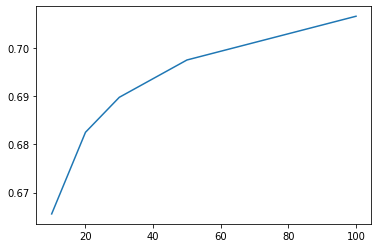

In [74]:
gb_res = auc_roc_results.mean(axis=1)
import matplotlib.pyplot as plt
%matplotlib inline
p = plt.plot(gb_res)
gb_res

График выше имеет отрицательную выпуклость, это означает, что чем больше деревьев используется, тем меньше пользы приносят новые деревья, при этом время выполнения линейно зависит от количества деревьев. Однако, график всё-таки возрастает. Поэтому, если позволяют ресурсы, то имеет смысл использовать больше 30 деревьев. Для ускорения обучения можно использовать только часть выборки или уменьшить глубину деревьев.

### Подход 2: логистическая регрессия

1. Оцените качество логистической регрессии с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. 

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
scaled_features = StandardScaler().fit_transform(X.values)
X_scaled = pd.DataFrame(scaled_features, index = X.index, columns = X.columns)

In [94]:
def accuracy_logistic(X, y, C_range = (-5, 2), C_count = 20):
    auc_roc_scores = []
    times = []
    C_list = np.logspace(*C_range, num = C_count)
    for C in C_list:
        start_time = datetime.datetime.now()
        lg = LogisticRegression(C=C, random_state=1404)
        score = cross_val_score(lg, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
        auc_roc_scores.append(score)
        times.append(datetime.datetime.now() - start_time)
    print(f'Время в среднем: {np.mean(times)}')
    return pd.DataFrame(auc_roc_scores, C_list)

In [95]:
auc_roc_results_logistic = accuracy_logistic(X_scaled, y)

Время в среднем: 0:00:03.891896


Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

Наилучший результат при C = 0.008858667904100823, значение 0.7164022547773058


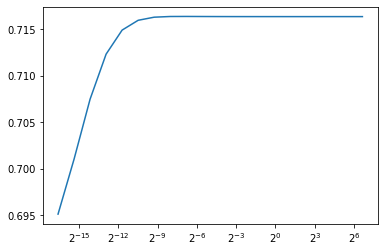

In [97]:
log_res = auc_roc_results_logistic.mean(axis=1)
plt.xscale('log',base=2) 
p = plt.plot(log_res)
print(f'Наилучший результат при C = {log_res.idxmax()}, значение {log_res.max()}')

Показатель выше самого лучшего показателя градиентного бустинга. При этом время выполнения намного меньше, это позволяет не идти на компромиссы при обучении модели. Тот факт, что логистическая регрессия работает хорошо, означает, что зависимость целевой переменной от признаков довольно линейна, поэтому линейные методы классификации хорошо будут работать для описания данной связи.

2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [100]:
X_removed = X_scaled.drop([f"{j}{i}_hero" for i in range(1, 6) for j in ['r', 'd']] + ["lobby_type"], axis=1)

In [101]:
auc_roc_results_logistic_removed = accuracy_logistic(X_removed, y)

Время в среднем: 0:00:04.071491


Наилучший результат при C = 0.008858667904100823, значение 0.716510509876658


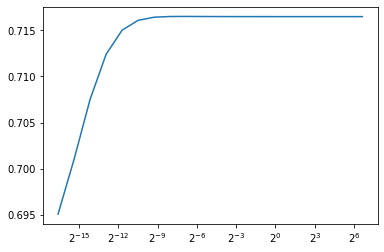

In [103]:
log_res_removed = auc_roc_results_logistic_removed.mean(axis=1)
plt.xscale('log',base=2) 
p = plt.plot(log_res_removed)
print(f'Наилучший результат при C = {log_res_removed.idxmax()}, значение {log_res_removed.max()}')

Качество практически не изменилось. Это вовсе не означает что удалённые признаки были не важны, так как они и до этого являлись шумом. Это означает, что модель оказалась довольна устойчива к целым 11 "шумовым" признакам. По сути, это логично: результат, скорре всего, никак не коррелирует с числовым значением удалённых признаков, поэтому в обученной модели их вес, скорее всего, близок к нулю

3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [117]:
heroes = np.unique(X_prev.loc[:, [f"{j}{i}_hero" for i in range(1, 6) for j in ['r', 'd']]].to_numpy())
print(f"Героев в выборке - {len(heroes)}. Потенциально героев - {heroes[-1]}+")

Героев в выборке - 108. Потенциально героев - 112+


4. Воспользуемся подходом "мешок слов" для кодирования информации о героях.

In [166]:
def bag_of_words(X_to_do, heroes):
    X_pick = np.zeros((X_to_do.shape[0], 112))
    for i, match_id in enumerate(X_to_do.index):
        for p in range(5):
            X_pick[i, X_to_do.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_pick[i, X_to_do.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
    #Убираем героев, не вошедших в выборку
    X_pick = pd.DataFrame(X_pick, index = X_to_do.index).loc[:, (X_pick != 0).any(axis=0)]
    return X_pick.rename(columns = dict(zip(X_pick.columns, [f"hero_{i}" for i in heroes])))

Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

In [154]:
X_pick = bag_of_words(X_removed, heroes)
X_super = pd.concat([X_removed, X_pick], axis=1)

5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

Время в среднем: 0:00:12.460953
Наилучший результат при C = 0.04832930238571752, значение 0.7518733702338259


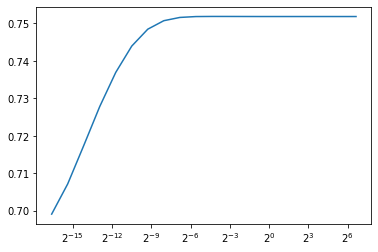

In [147]:
auc_roc_results_super = accuracy_logistic(X_super, y)
log_res_super = auc_roc_results_super.mean(axis=1)
plt.xscale('log',base=2) 
p = plt.plot(log_res_super)
print(f'Наилучший результат при C = {log_res_super.idxmax()}, значение {log_res_super.max()}')

Качество значительно улучшилось, что очевидно. До этого "мусорные" признаки не предоставляли никакой информации, а сейчас были добавлены информативные признаки в виде используемых героев. Действительно, различные герои имеют различный винрейт, поэтому более сильные герои имеют больше шансов на победу.

6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [150]:
final_model = LogisticRegression(C=0.04832930238571752, random_state=1404, max_iter=150)
final_model.fit(X_super, y)

LogisticRegression(C=0.04832930238571752, max_iter=150, random_state=1404)

In [185]:
features_test = pd.read_csv('./features_test.csv', index_col='match_id').fillna(0)
heroes_test = np.unique(features_test.loc[:, [f"{j}{i}_hero" for i in range(1, 6) for j in ['r', 'd']]].to_numpy())
X_test =  features_test.drop([f"{j}{i}_hero" for i in range(1, 6) for j in ['r', 'd']] + ["lobby_type"], axis=1)
scaled_features = StandardScaler().fit_transform(X_test)
X_test  = pd.DataFrame(scaled_features, index = X_test.index, columns = X_test.columns)
X_test = pd.concat([X_test, bag_of_words(features_test, heroes_test)], axis=1)


In [187]:
pred = final_model.predict_proba(X_test)[:, 1]

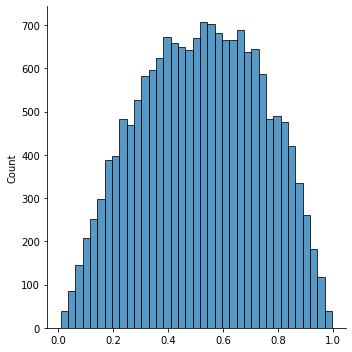

In [194]:
import seaborn as sns
p = sns.displot(pred)

Распределение ответов выглядит адекватно

In [200]:
output = pd.DataFrame(pred, index = features_test.index, columns = ['radiant_win'])

In [202]:
output.to_csv('answer.csv')

In [203]:
print(min(pred), max(pred))

0.008543874997718807 0.9963968730626978
